# Практическое задание к уроку 1 (2 неделя).
## Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
df = pd.read_csv("bikes_rent.csv")
df.head(5)
# (0 баллов)
# Считайте данные и выведите первые 5 строк


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

<Figure size 432x288 with 0 Axes>

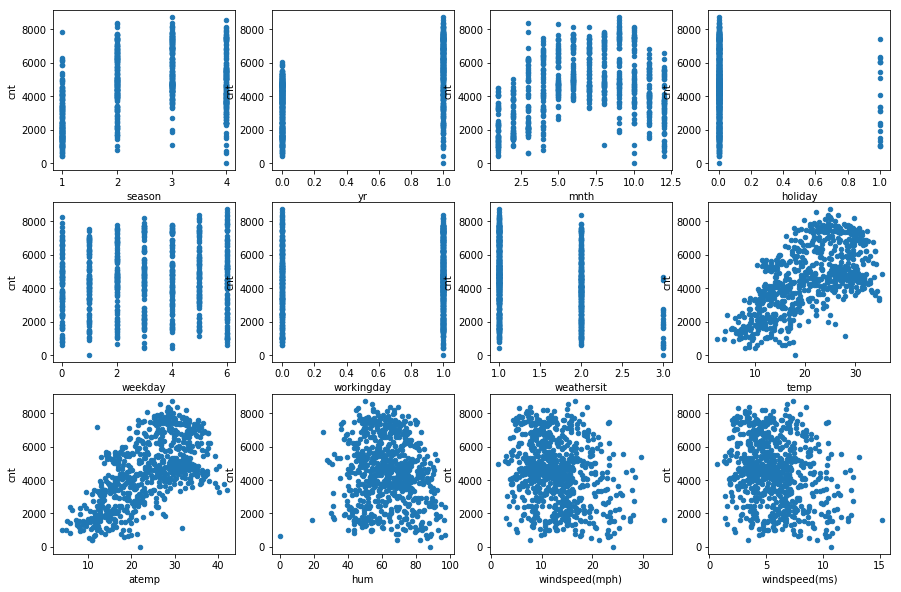

In [119]:
plt.clf()
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

__Блок 1. Ответьте на вопросы (каждый 0.5 балла):__
1. Каков характер зависимости числа прокатов от месяца? 
   * ответ: график напоминает параболу, в летние месяцы число прокатов повышается, в остальные снижается
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: температура. Как обычная, так и ощущаемая (temp, atemp)

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [14]:
df.drop("cnt", axis = 1).corrwith(df["cnt"])
# Код 1.1 (0.5 балла)
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:


season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [16]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
df.filter(['temp','atemp','hum','windspeed(mph)', 'windspeed(ms)','cnt']).corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [42]:
# Код 1.3 (0.5 балла)
# Выведите средние признаков
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [20]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [85]:
df_shuffled = shuffle(df, random_state=123)
#X = scale(df_shuffled[df_shuffled.columns[:-1]])
X = scale(df_shuffled.drop('cnt',axis=1)) #стандартизация признаков
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [26]:
from sklearn.linear_model import LinearRegression

In [86]:
# Код 2.1 (1 балл)
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns
lr = LinearRegression()
lr.fit(X,y)
list(zip(df_shuffled.columns, lr.coef_))

[('season', 570.8637158147758),
 ('yr', 1021.9697835678162),
 ('mnth', -141.29804977407753),
 ('holiday', -86.76116112336203),
 ('weekday', 137.22472809775428),
 ('workingday', 56.392584525160245),
 ('weathersit', -330.2289467243876),
 ('temp', 367.46828883327345),
 ('atemp', 585.565376130523),
 ('hum', -145.6091150277622),
 ('windspeed(mph)', 12457617836216.55),
 ('windspeed(ms)', -12457617836415.002)]

In [89]:
X[:1]

array([[-0.44735043,  0.99863295, -0.44058948, -0.171981  ,  0.50051332,
         0.67970582,  1.11042659,  0.35323191,  0.38617216,  0.98670216,
        -0.7332988 , -0.7332988 ]])

Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [23]:
from sklearn.linear_model import Lasso, Ridge

In [35]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией и выведите веса
lasso = Lasso()
lasso.fit(X,y)
list(zip(df_shuffled.columns,lasso.coef_))

[('season', 560.2416160308868),
 ('yr', 1019.4634940657199),
 ('mnth', -128.73062703678758),
 ('holiday', -86.15278133371105),
 ('weekday', 137.34789390496303),
 ('workingday', 55.21237064135682),
 ('weathersit', -332.36985696234876),
 ('temp', 376.3632362096975),
 ('atemp', 576.5307935045522),
 ('hum', -144.1291550034859),
 ('windspeed(mph)', -197.13968940248512),
 ('windspeed(ms)', -2.8050416772134453e-08)]

In [36]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией и выведите веса
ridge = Ridge()
ridge.fit(X,y)
list(zip(df_shuffled.columns,ridge.coef_))

[('season', 563.0645722520125),
 ('yr', 1018.9483787875281),
 ('mnth', -131.8733202824726),
 ('holiday', -86.74609799709249),
 ('weekday', 138.00511117871903),
 ('workingday', 55.903110375064536),
 ('weathersit', -332.34978849907293),
 ('temp', 386.45788919193535),
 ('atemp', 566.3470470600411),
 ('hum', -145.07132729867263),
 ('windspeed(mph)', -99.25944108184098),
 ('windspeed(ms)', -99.25944115429242)]

### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [93]:
# Код 3.1 (1 балл)
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),
# а затем обучите Ridge и запишите веса в coefs_ridge.
i=0
for a in alphas:
    lasso = Lasso(alpha = a)
    lasso.fit(X,y)
    ridge = Ridge(alpha=a)
    ridge.fit(X,y)
    coefs_lasso[i]=lasso.coef_
    coefs_ridge[i]=ridge.coef_
    i+=1
 

In [96]:
t=pd.DataFrame(coefs_ridge,index=alphas)
t.columns=df.columns[:-1]
t

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
1,563.064572,1018.948379,-131.873320,-86.746098,138.005111,55.903110,-332.349788,386.457889,566.347047,-145.071327,-99.259441,-99.259441
51,461.178632,954.307742,-41.565450,-84.913470,126.603667,54.251691,-313.275151,458.901477,481.443500,-151.291010,-101.627315,-101.627315
101,403.976530,898.083622,5.674243,-81.911062,117.941411,52.728484,-298.408981,455.289868,467.431417,-152.686051,-102.101671,-102.101671
151,366.604239,848.463465,34.027283,-78.771965,110.680120,51.257192,-286.125159,447.479825,455.754030,-151.483206,-102.005376,-102.005376
201,339.745290,804.251048,52.489873,-75.717408,104.403464,49.841895,-275.486095,438.509689,444.764274,-148.943970,-101.586385,-101.586385
251,319.158641,764.561434,65.152007,-72.819708,98.878804,48.484525,-266.002556,429.214123,434.235235,-145.698115,-100.964711,-100.964711
301,302.636060,728.708540,74.138281,-70.098983,93.955811,47.185338,-257.390629,419.926152,424.121922,-142.089345,-100.208620,-100.208620
351,288.913276,696.145816,80.660457,-67.554852,89.528675,45.943467,-249.471395,410.800184,414.409373,-138.316538,-99.360661,-99.360661
401,277.213216,666.429747,85.459254,-65.178706,85.518667,44.757303,-242.124399,401.911945,405.085853,-134.499038,-98.449064,-98.449064
451,267.031090,639.195368,89.012323,-62.958906,81.864909,43.624770,-235.263997,393.297986,396.138155,-130.709872,-97.493434,-97.493434


Визуализируем динамику весов при увеличении параметра регуляризации:

Text(0.5,1,'Ridge')

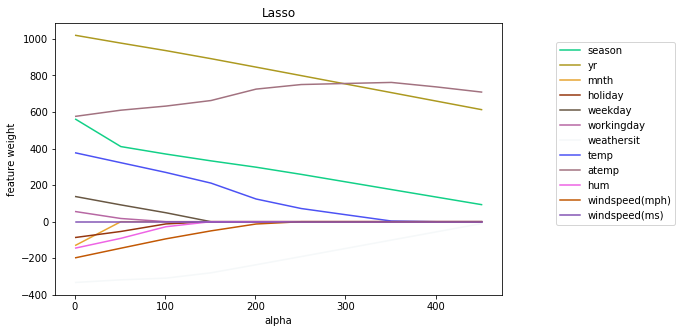

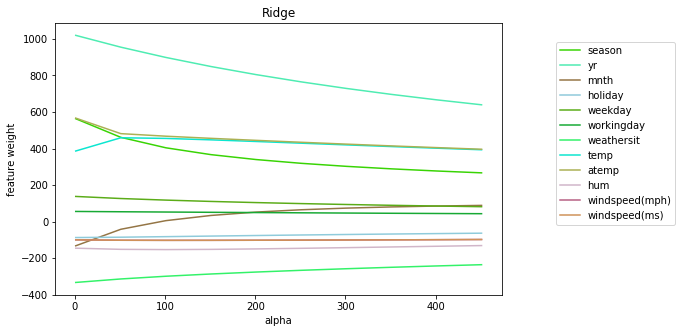

In [95]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

__Блок 2. Ответьте на вопросы (каждый 0.25 балла)__:
1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
    * Ответ: Lasso
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: При увеличении alpha веса перед признакама уходят в ноль. Потому что значение компонента регуляризации растет в бесконечность, и мы начинаем минимизироватиь именно его путем уменьшения количества ненулевых весов
1. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * Ответ:   да, можно. при этом Ridge не исключает признак, так как ему важна сумма всех весов, в то времмя как Lasso важна кроме суммы весов еще и количество ненулевых весов
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * Ответ: Lasso

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [44]:
from sklearn.linear_model import LassoCV

mse [[863936.50981215 826364.11936907 862993.29751897]
 [860479.31511365 821110.1817776  853075.13780626]
 [857344.83606082 816153.27782428 843628.81286099]
 [854526.73639431 811496.34805693 834654.45357263]
 [852024.62341384 807139.39657173 826152.16399015]
 [849838.18755425 803082.42338526 818122.01934907]
 [847967.16232762 799325.42849761 810564.07404746]
 [846411.31812808 795868.41190876 803478.3674151 ]
 [845170.45707972 792711.37361871 796864.92788593]
 [844244.40861679 789854.31362747 790723.77601555]
 [843633.02568868 787297.23193504 785058.69560905]
 [843336.18149882 785040.12854141 779861.12465128]
 [843353.76670095 783083.00344659 775139.90236011]
 [843616.44582031 781425.85665058 770886.43550573]
 [843608.19759457 780068.68815337 767109.44006007]
 [844145.56423514 777586.36117475 763800.36416062]
 [845219.34650306 775290.91645251 760967.79203408]
 [846828.77496205 773628.85569644 755626.71475017]
 [848973.80188236 772598.49562777 749620.88682029]
 [851701.88999353 878936.94

Text(0,0.5,'average MSE')

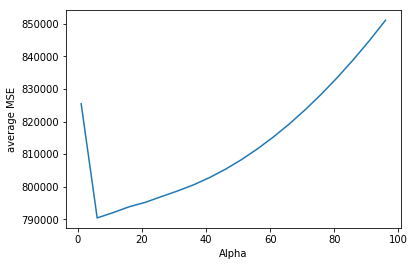

In [105]:
# Код 3.2 (1 балл)
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)
lcv = LassoCV(alphas=alphas)
lcv.fit(X,y)
print("mse",lcv.mse_path_) # ошибки по всем разбиениям по каждой альфе
print("alphas", lcv.alphas_) # перечисляем все альфы
print("best", lcv.alpha_ ) # наилучшая выбранная альфа
avgmses=list(map(np.mean,lcv.mse_path_)) #среднее для каждой альфы
avgmses
plt.plot(lcv.alphas_,avgmses)
plt.xlabel('Alpha')
plt.ylabel('average MSE')

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

Text(0,0.5,'min MSE')

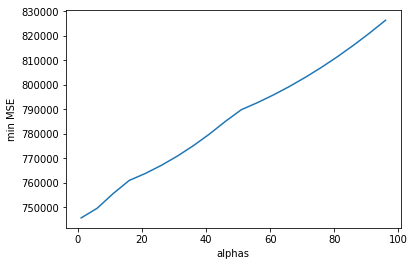

In [81]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_
minmses=list(map(min,lcv.mse_path_))
plt.plot(lcv.alphas_, list(minmses))
plt.xlabel('alphas')
plt.ylabel('min MSE')


In [83]:
list(zip(lcv.alphas_,list(minmses)))

[(96, 826364.1193690717),
 (91, 821110.1817776044),
 (86, 816153.2778242799),
 (81, 811496.3480569314),
 (76, 807139.3965717288),
 (71, 803082.4233852644),
 (66, 799325.4284976064),
 (61, 795868.4119087555),
 (56, 792711.3736187097),
 (51, 789854.3136274704),
 (46, 785058.6956090488),
 (41, 779861.1246512807),
 (36, 775139.9023601072),
 (31, 770886.4355057252),
 (26, 767109.4400600698),
 (21, 763800.3641606206),
 (16, 760967.7920340818),
 (11, 755626.7147501722),
 (6, 749620.8868202912),
 (1, 745668.6059608078)]

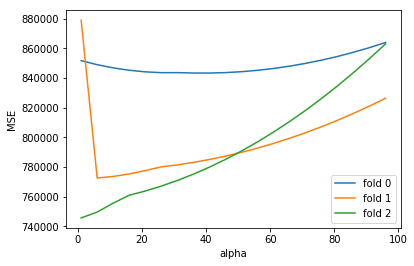

In [59]:
for i in [0,1,2]:
    plt.plot(lcv.alphas_,lcv.mse_path_[:,i], label="fold {}".format(i))
    plt.xlabel('alpha')
    plt.ylabel('MSE')
plt.legend()

In [113]:
list(zip(df.columns,lcv.coef_))
pd.Series(lcv.coef_,index=df.columns[:-1]).apply(abs).sort_values()

windspeed(ms)     2.685421e-08
workingday        5.155709e+01
holiday           8.329396e+01
mnth              1.000395e+02
weekday           1.325045e+02
hum               1.400074e+02
windspeed(mph)    1.917714e+02
weathersit        3.305599e+02
temp              3.706799e+02
season            5.320190e+02
atemp             5.813969e+02
yr                1.015060e+03
dtype: float64

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

__Блок 3. Ответьте на вопросы (каждый 0.5 балла):__
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * Ответ: yr (1015), atemp(581), season(532), temp(370). Возрастающая зависимость видна, но нет ограничения.Например, при очень жаркой погоде вряд ли будут желающие покататься. Кроме этого возрастающее количество клиентов с годами показывает, что дела у компании идут хорошо, но это не гарантирует, что и дальше юудет так, и что клиенты захотят брать велосепид в прокат только от того, что число, обозначающее год, увеличилось
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * Ответ: weathersit (-330), windspeed(mph)(-192), hum(-140) Убывающая линейная зависимость видна, но не явно выражена. Да, возможно увеличиение этих признаков повлияет на уменьшение количества людей, желающих взять велосипеды
1. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * Ответ: windspeed(ms), он был исключен, так как равнозначен признаку windspeed(mph). Два других признака с наименьшими по модулю весами (workingday и holiday)  нелинейны и слабо влияют на спрос на велосипеды

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.